# Quanvolutional Neural Networks
A Quanvolutional Neural Network (QNN) is a type of hybrid quantum-classical neural network that applies quantum operations to the data before processing it through a classical convolutional neural network (CNN). The quantum part (quanvolution) involves encoding data into a quantum state, applying quantum gates, and then measuring the results. These quantum-transformed features are then passed through a classical CNN, enhancing the network's ability to capture complex patterns, especially in high-dimensional data.

### convolutional neural network

A *Convolutional Neural Network* (CNN) is a type of deep learning model primarily used for processing grid-like data, such as images. CNNs are particularly effective for tasks like image recognition, object detection, and computer vision.

### How CNNs Work
*Input*: The input to a CNN is usually an image represented as a grid of pixels.
*Feature Extraction*: Convolutional layers extract features from the image, such as edges, shapes, and textures.
*Dimensionality Reduction*: Pooling layers reduce the size of the feature maps while retaining important information.
*Classification*: The fully connected layers process the extracted features to output a classification label, such as identifying an object in the image.


### Quantum Convolution
Quantum Convolution is a concept that extends the idea of classical convolution (as used in Convolutional Neural Networks) into the quantum computing domain. It is used in Quantum Convolutional Neural Networks (QCNNs) or other hybrid quantum-classical models.


Now we install package in google colab

In [5]:
# Install the required packages
!pip install pennylane tensorflow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.8 MB/s eta 0:00:00


This section , we import packages for further use

In [6]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

### Main hyper-parameters model settings

In [15]:
n_epochs = 30
n_layers = 1
n_train = 50
n_test = 30

# chage save path directory
SAVE_PATH = "/home/quanvolutional_nn/"
PREPROCESS = True
np.random.seed(0)
tf.random.set_seed(0)

### Loading of the MNIST Dataset
Loading MNIST dataset for train & test data selection

In [16]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

Then we normalize the train & test images pixel values within 0 or 1

In [ ]:
# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

### Quantum circuit as a convolution kernel
Here, we create a qml device with simulating $4$ qubits.
Then, `rand_params` create with `np.random.uniform` from size `n_layers` to 4
Next, circuit function we declare embedding layer of local $R_y$ rotations.
In this circuit function, we generate a Random quantum circuit & return the measurement producing 4 classical output values.

In [30]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

# Example input: an array of four values
phi_input = [1/4, 1/4, 1/4, 1/4]

print(qml.draw(circuit)(phi_input))

0: ──RY(0.79)─╭RandomLayers(M0)─┤  <Z>
1: ──RY(0.79)─├RandomLayers(M0)─┤  <Z>
2: ──RY(0.79)─├RandomLayers(M0)─┤  <Z>
3: ──RY(0.79)─╰RandomLayers(M0)─┤  <Z>

M0 = 
[[2.9757192  1.17076064 4.63019346 1.36062601]]


Next function defines the convolution scheme. Images are divided into squares of $2 \times 2$ pixels.The Expectation values are mapped into different channels.

In [18]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

## Quantum pre-processing of the dataset
Here, pre-processing layer is applied for getting more efficient images data. 

In [19]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


**Visualize the effect of the quantum convolution layer on a batch
of samples**:


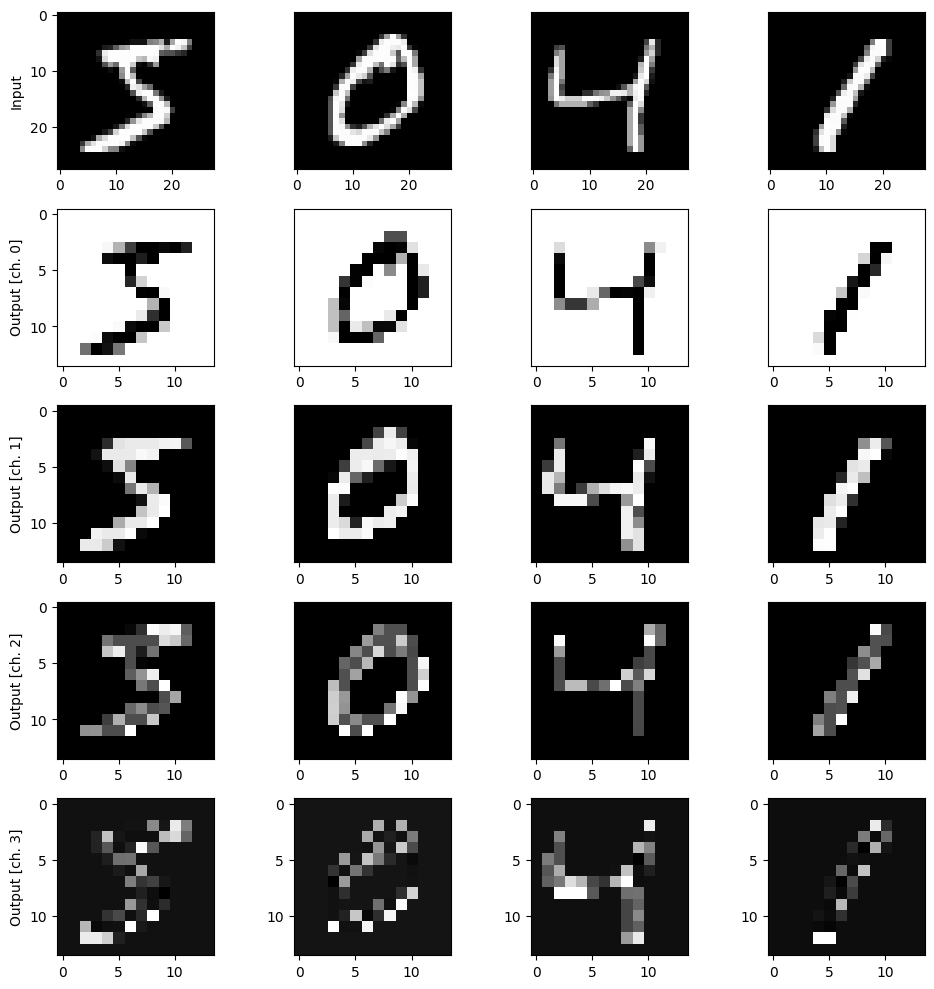

In [20]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

## Hybrid quantum-classical model
We  create a simple quantum-classical model with keras.We train to classify the $10$ different digits of the MNIST dataset.Then, use *adam* as a optimizer & *sparse_categorical_crossentropy* as a loss parameter.


In [21]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

## Training
We first initialize an instance of the model, then we train and validate it with the dataset(pre-processed by a quantum convolution) that has been batch size 4 & epochs 30.

In [22]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 2s - 129ms/step - accuracy: 0.1600 - loss: 2.7442 - val_accuracy: 0.1333 - val_loss: 2.3111
Epoch 2/30
13/13 - 0s - 11ms/step - accuracy: 0.3000 - loss: 2.0056 - val_accuracy: 0.2667 - val_loss: 2.0712
Epoch 3/30
13/13 - 0s - 9ms/step - accuracy: 0.5200 - loss: 1.6807 - val_accuracy: 0.4000 - val_loss: 1.8782
Epoch 4/30
13/13 - 0s - 10ms/step - accuracy: 0.6000 - loss: 1.3713 - val_accuracy: 0.5667 - val_loss: 1.7301
Epoch 5/30
13/13 - 0s - 9ms/step - accuracy: 0.7800 - loss: 1.1332 - val_accuracy: 0.6333 - val_loss: 1.6203
Epoch 6/30
13/13 - 0s - 10ms/step - accuracy: 0.8600 - loss: 0.9382 - val_accuracy: 0.6333 - val_loss: 1.5266
Epoch 7/30
13/13 - 0s - 10ms/step - accuracy: 0.9000 - loss: 0.7860 - val_accuracy: 0.6333 - val_loss: 1.4484
Epoch 8/30
13/13 - 0s - 10ms/step - accuracy: 0.9600 - loss: 0.6648 - val_accuracy: 0.6333 - val_loss: 1.3866
Epoch 9/30
13/13 - 0s - 11ms/step - accuracy: 0.9800 - loss: 0.5669 - val_accuracy: 0.6333 - val_loss: 1.3354
Epoch 10/30

Same process but here valisation data chaged with test_images.

In [23]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 65ms/step - accuracy: 0.1400 - loss: 2.2589 - val_accuracy: 0.2000 - val_loss: 2.0789
Epoch 2/30
13/13 - 0s - 12ms/step - accuracy: 0.5200 - loss: 1.8601 - val_accuracy: 0.4000 - val_loss: 1.9523
Epoch 3/30
13/13 - 0s - 9ms/step - accuracy: 0.7000 - loss: 1.5862 - val_accuracy: 0.4667 - val_loss: 1.8324
Epoch 4/30
13/13 - 0s - 11ms/step - accuracy: 0.8200 - loss: 1.3614 - val_accuracy: 0.5000 - val_loss: 1.7200
Epoch 5/30
13/13 - 0s - 10ms/step - accuracy: 0.8800 - loss: 1.1743 - val_accuracy: 0.5000 - val_loss: 1.6212
Epoch 6/30
13/13 - 0s - 6ms/step - accuracy: 0.8800 - loss: 1.0189 - val_accuracy: 0.5333 - val_loss: 1.5384
Epoch 7/30
13/13 - 0s - 11ms/step - accuracy: 0.8800 - loss: 0.8900 - val_accuracy: 0.5667 - val_loss: 1.4701
Epoch 8/30
13/13 - 0s - 7ms/step - accuracy: 0.9400 - loss: 0.7827 - val_accuracy: 0.6000 - val_loss: 1.4136
Epoch 9/30
13/13 - 0s - 10ms/step - accuracy: 0.9800 - loss: 0.6928 - val_accuracy: 0.6333 - val_loss: 1.3662
Epoch 10/30
1

## Results

We can finally plot the test accuracy and the test loss with respect to
the number of training epochs.


<ipython-input-24-c3ef9ba498fb>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


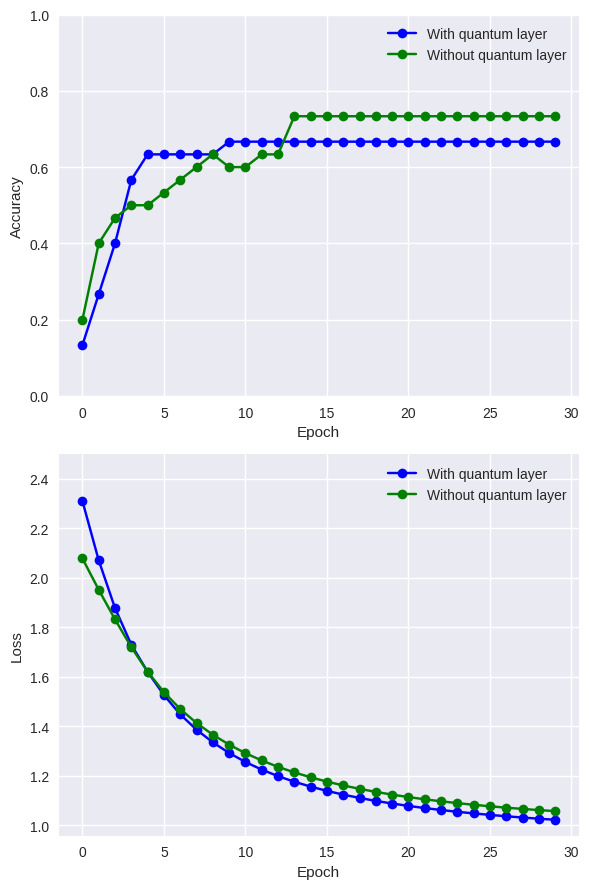

In [24]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

References
==========
-  Maxwell Henderson, Samriddhi Shakya, Shashindra Pradhan, Tristan
    Cook. \"Quanvolutional Neural Networks: Powering Image Recognition
    with Quantum Circuits.\"
    [arXiv:1904.04767](https://arxiv.org/abs/1904.04767), 2019.